# Import libraries

In [1]:
# 필요한 library가 있다면 추가하셔도 됩니다.

# load all necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
%matplotlib inline

# libraries for nlp task
import regex as re
import nltk, re, string
from nltk import FreqDist
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import torch
import torch.nn as nn
torch.manual_seed(42)

# filtering warnings
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
pd.set_option('display.max_columns', None)

from nltk.corpus import wordnet, stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyundong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hyundong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hyundong\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Preprocessing

data의 preprocessing을 진행합니다. 아래 조건에 맞게 전처리를 진행합니다. 필요한만큼 셀을 사용하시면 됩니다.

조건에 맞는 전처리를 진행하고 각각의 실행 결과(output) 창을 보여주어야합니다.

- Sentence의 문자를 모두 소문자로 변경
- stopwords의 english stopwords 제거
- WordNetLemmatizer를 이용하여 lemmatize 진행
- 정규 표현식을 사용하여 url 제거
- 정규 표현식을 사용하여 알파벳을 제외한 punctuation 포함 문자 제거
- sklearn의 LabelEncoder를 이용하여 Sentiment에 대해 label encoding 진행
- FreqDist를 사용하여 word encoding
- 제일 길이가 긴 문장을 기준으로 zero-padding 진행

In [2]:
train = pd.read_csv('./train_data.csv') 
train

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5795,"In 2009 , it reported net sales of approximate...",neutral
5796,"H1 '08 H1 '07 Q2 '08 Q2 '07 in mln euro , unle...",neutral
5797,`` Low energy consumption and flexible loading...,neutral
5798,$SPY $MITK fast 56pc dive http://stks.co/3ffN $$,negative


In [3]:
train['Sentiment'].value_counts()

Sentiment
neutral     3115
positive    1838
negative     847
Name: count, dtype: int64

In [4]:
def cleaning_sentences(data):     
    data = data.lower().split()
        
    stops = set(stopwords.words('english'))
    data = [word for word in data if not word in stops] 

    lemmatizer = WordNetLemmatizer()
    data = [lemmatizer.lemmatize(word) for word in data]

    data = ' '.join(data)
    data = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",' ',data)   
    data = re.sub('[^a-zA-z]',' ',data)

    return data


In [5]:
train['Sentence'] = train['Sentence'].apply(lambda x : cleaning_sentences(x))

label_encoder = LabelEncoder()
train['Sentiment'] = label_encoder.fit_transform(train['Sentiment'])

all_words = ' '.join(train['Sentence']).split()
freq_dist = FreqDist(all_words)

sorted_word_freq = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)

word_index = {word: index+1 for index, (word,_) in enumerate(sorted_word_freq)}

train['Sentence'] = train['Sentence'].apply(lambda x : [word_index[word] for word in x.split()])

# 제일 길이가 긴 문장을 기준으로 zero-padding 진행
max_len = max(train['Sentence'].apply(len))
train['Sentence'] = pad_sequences(train['Sentence'], maxlen=max_len, padding='post').tolist()

# 최종 전처리된 데이터 확인
train.head()


,Sentence,Sentiment
0,"[3289, 56, 2596, 1149, 2, 1668, 39, 670, 618, ...",2
1,"[4747, 2598, 3291, 137, 2599, 0, 0, 0, 0, 0, 0...",0
2,"[77, 14, 529, 2, 11, 5, 1670, 1, 24, 1, 24, 17...",2
3,"[62, 7, 295, 3292, 1895, 262, 88, 3, 16, 13, 1...",1
4,"[217, 1150, 358, 359, 833, 41, 141, 587, 4749,...",1


# Model
전처리를 진행한 데이터를 이용하여 학습을 진행하는 부분입니다. 아래의 조건들에 맞는 코드를 작성하고, 결과를 확인하면 됩니다. 필요한만큼 셀을 사용하시면 됩니다.

조건에 맞는 코드를 작성하고, 결과창(output)을 보여주어야합니다.

- train data와 validation data 분리 → train : 8 / valid : 2 비율로 분리
- target의 경우 classification이기 때문에 categorical하게 바꿔야 합니다.
- MLP 모델 구현 → 하이퍼파라미터 설정은 자유
- train / valid 과정 구현
- train set loss/ validation set loss에 대한 learning curve 출력하기
- 학습된 model은 학번_model.pth로 파일 save → ex) 20XXXXXXX_model.pth

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
X_train, X_valid, y_train, y_valid = train_test_split(train['Sentence'],train['Sentiment'],test_size=0.2,random_state=42)

y_train = to_categorical(y_train,num_classes=3)
y_valid = to_categorical(y_valid,num_classes=3)

X_train = torch.FloatTensor(X_train.tolist()).to(device)
X_valid = torch.FloatTensor(X_valid.tolist()).to(device)
y_train = torch.FloatTensor(y_train.tolist()).to(device)
y_valid = torch.FloatTensor(y_valid.tolist()).to(device)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([4640, 42]) torch.Size([4640, 3]) torch.Size([1160, 42]) torch.Size([1160, 3])


Epoch 0, Train Loss: 1.165626883506775, Valid Loss: 1.1629374027252197
Epoch 100, Train Loss: 1.0905544757843018, Valid Loss: 1.0900086164474487
Epoch 200, Train Loss: 1.061585783958435, Valid Loss: 1.0564857721328735
Epoch 300, Train Loss: 1.0419607162475586, Valid Loss: 1.0240249633789062
Epoch 400, Train Loss: 1.0339853763580322, Valid Loss: 1.0116071701049805
Epoch 500, Train Loss: 1.0308290719985962, Valid Loss: 1.008539080619812
Epoch 600, Train Loss: 1.0285065174102783, Valid Loss: 1.0062123537063599
Epoch 700, Train Loss: 1.0260850191116333, Valid Loss: 1.0035064220428467
Epoch 800, Train Loss: 1.0235334634780884, Valid Loss: 1.0011628866195679
Epoch 900, Train Loss: 1.0214219093322754, Valid Loss: 1.0002410411834717
Epoch 1000, Train Loss: 1.019686222076416, Valid Loss: 0.9997731447219849
Epoch 1100, Train Loss: 1.0186487436294556, Valid Loss: 0.9992079138755798
Epoch 1200, Train Loss: 1.0178979635238647, Valid Loss: 0.9987949728965759
Epoch 1300, Train Loss: 1.017360091209411

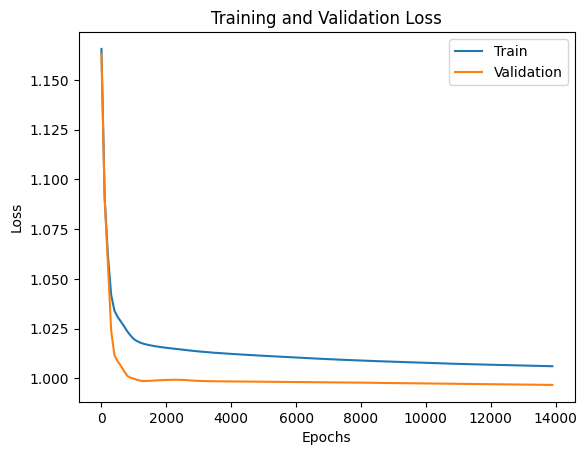

In [7]:
model = nn.Sequential(
          nn.Linear(42, 10), 
          nn.ReLU(),
          nn.Linear(10, 10), 
          nn.ReLU(),
          nn.Linear(10, 10), 
          nn.ReLU(),
          nn.Linear(10, 10), 
          nn.ReLU(),          
          nn.Linear(10, 3), 
          nn.Softmax(dim=1)  
          ).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=None, reduction='mean').to(device) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

train_losses = []
valid_losses = []

epochs = 13920 # 나누기 1 epoch = 4640, 13920 = 3 epoch

for epoch in range(epochs):
    optimizer.zero_grad()   
    hypothesis = model(X_train) 
    cost = criterion(hypothesis, y_train)
    cost.backward()
    optimizer.step()
  
    if epoch % 100 == 0:
        with torch.no_grad():           
            train_hypothesis = model(X_train)
            train_loss = criterion(train_hypothesis, y_train)
            train_losses.append(train_loss.item())

            valid_hypothesis = model(X_valid)
            valid_loss = criterion(valid_hypothesis, y_valid)
            valid_losses.append(valid_loss.item())

            print(f'Epoch {epoch}, Train Loss: {train_loss.item()}, Valid Loss: {valid_loss.item()}')

# Learning curve
plt.plot(range(0, epochs, 100), train_losses, label='Train')
plt.plot(range(0, epochs, 100), valid_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
with torch.no_grad():
    hypothesis = model(X_valid)
    predicted = (hypothesis > 0.7).float()
    accuracy = (predicted == y_valid).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', y_valid.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item())

모델의 출력값(Hypothesis):  [[1.5598808e-06 9.9989319e-01 1.0526987e-04]
 [2.9499563e-05 9.9820209e-01 1.7683482e-03]
 [1.4780781e-08 9.9999583e-01 4.1198064e-06]
 ...
 [3.3930424e-12 1.0000000e+00 1.8789448e-08]
 [4.4521275e-03 5.4049700e-01 4.5505080e-01]
 [1.3622259e-01 4.7655463e-01 3.8722286e-01]]
모델의 예측값(Predicted):  [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
실제값(Y):  [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
정확도(Accuracy):  0.7014367580413818


In [9]:
torch.save(model.state_dict(), 'model_weights.pth')

# 참고 자료

- 아래 markdown cell에 내용 및 코드를 참고한 부분을 작성하시면 됩니다.

딥러닝을 이용한 자연어 처리 입문 : https://wikidocs.net/49071

PyTorch로 시작하는 딥 러닝 입문 : https://wikidocs.net/61010

